In [7]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [8]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

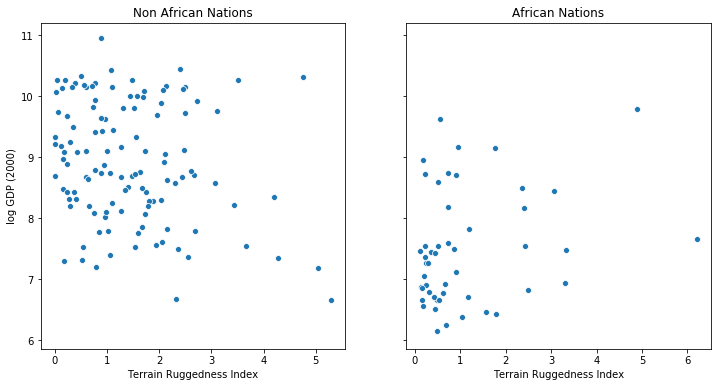

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            np.log(non_african_nations["rgdppc_2000"]),
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
            np.log(african_nations["rgdppc_2000"]),
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [10]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

p = 2  # number of features
regression_model = RegressionModel(p)

In [11]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)
num_iterations = 1000
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

def main():
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.named_parameters():
        print(name, param.data.numpy())

main()

[iteration 0050] loss: 3723.7849
[iteration 0100] loss: 1777.9851
[iteration 0150] loss: 1226.7543
[iteration 0200] loss: 927.1514
[iteration 0250] loss: 706.6473
[iteration 0300] loss: 536.0911
[iteration 0350] loss: 408.0940
[iteration 0400] loss: 316.1810
[iteration 0450] loss: 252.9710
[iteration 0500] loss: 211.2545
[iteration 0550] loss: 184.7950
[iteration 0600] loss: 168.6502
[iteration 0650] loss: 159.1673
[iteration 0700] loss: 153.8036
[iteration 0750] loss: 150.8815
[iteration 0800] loss: 149.3482
[iteration 0850] loss: 148.5732
[iteration 0900] loss: 148.1960
[iteration 0950] loss: 148.0193
[iteration 1000] loss: 147.9397
Learned parameters:
factor 0.37248388
linear.weight [[-1.9051107  -0.18619306]]
linear.bias [9.188873]


In [12]:
reg_model = RegressionModel(p)
loc = torch.zeros(1, 1)
scale = torch.ones(1, 1)
# define a unit normal prior
prior = Normal(loc, scale)
# overload the parameters in the regression module with samples from the prior
lifted_module = pyro.random_module("regression_module", reg_model, prior)
# sample a nn from the prior
sampled_reg_model = lifted_module()

In [13]:
def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, 2), torch.ones(1, 2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
    scale = pyro.sample("sigma", Uniform(0., 10.))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean

In [14]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [15]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [16]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train()

[iteration 0001] loss: 3.3938
[iteration 0101] loss: 3.1657
[iteration 0201] loss: 3.0490
[iteration 0301] loss: 2.5548
[iteration 0401] loss: 2.0392
[iteration 0501] loss: 1.6778
[iteration 0601] loss: 1.5116
[iteration 0701] loss: 1.4920
[iteration 0801] loss: 1.5403
[iteration 0901] loss: 1.4920


In [36]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-2.2372,  0.3401, -1.8984, -0.2049,  9.1463], requires_grad=True)
auto_scale tensor([0.0922, 0.0709, 0.1162, 0.0460, 0.0781], grad_fn=<AddBackward0>)


In [18]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)

In [38]:
# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

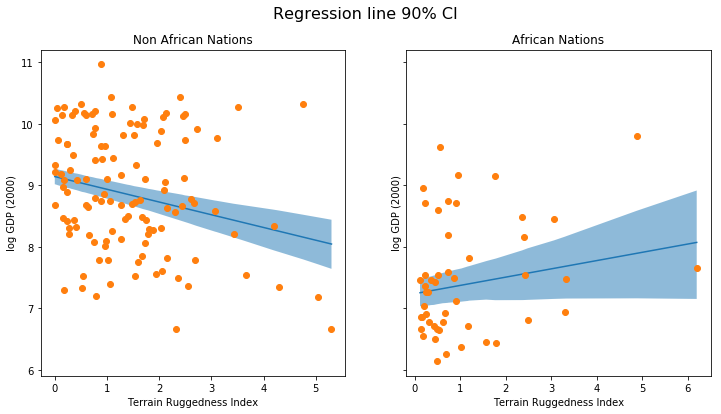

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

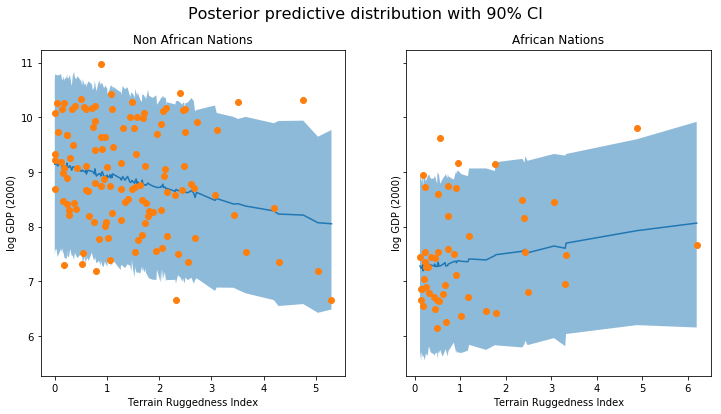

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Density of Slope : log(GDP) vs. Terrain Ruggedness')

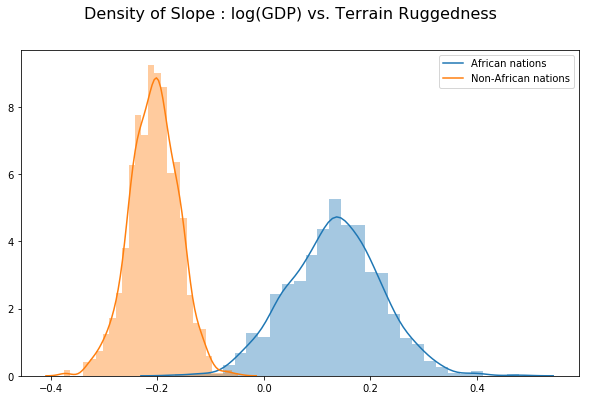

In [41]:
# we need to prepend `module$$$` to all parameters of nn.Modules since
# that is how they are stored in the ParamStore
weight = get_marginal(posterior, ['module$$$linear.weight']).squeeze(1).squeeze(1)
factor = get_marginal(posterior, ['module$$$factor'])
gamma_within_africa = weight[:, 1] + factor.squeeze(1)
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)